In [1]:
import os

import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [3]:
os.chdir('..')

In [4]:
from src.enc_dec_regression_arch import enc_dec_regression

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Setting seed for reproducibility
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [7]:
X_train_combined = np.load('./data/X_train_combined.npy')
y_train_combined = np.load('./data/y_train_combined.npy')

In [8]:
X_val = np.load('./data/X_val.npy')
y_val = np.load('./data/y_val.npy')

X_train_combined.shape, y_train_combined.shape, X_val.shape, y_val.shape

((130050, 32, 32, 32, 1),
 (130050, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1))

------
#### Taking a sample of data to make sure the dimensions are fine or not. Later, will try to run it on all samples.

In [9]:
sample_size_train = int(0.9 * X_train_combined.shape[0])
sample_size_val = int(0.9 * X_val.shape[0])

indices_train = np.random.choice(X_train_combined.shape[0], sample_size_train, replace=False)
indices_val = np.random.choice(X_val.shape[0], sample_size_val, replace=False)

X_train_sample = X_train_combined[indices_train]
y_train_sample = y_train_combined[indices_train]
X_val_sample = X_val[indices_val]
y_val_sample = y_val[indices_val]

X_train_sample.shape, y_train_sample.shape, X_val_sample.shape, y_val_sample.shape

((117045, 32, 32, 32, 1),
 (117045, 32, 32, 32, 1),
 (17212, 32, 32, 32, 1),
 (17212, 32, 32, 32, 1))

In [10]:
# Parameters
Ngrid = 32  # grid size

In [12]:
enc_dec_model = enc_dec_regression(Ngrid)

2024-03-01 09:24:51.753683: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 09:24:52.177201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [13]:
# Compile the model
enc_dec_model.compile(optimizer=Adam(), 
                      loss='mse',
                      metrics=['mae'],
                      run_eagerly=True)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)
checkpoint = ModelCheckpoint('models/initial/010324_90p_samp_augment.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [17]:
history = enc_dec_model.fit(x=X_train_sample, 
                            y=y_train_sample, 
                            validation_data=(X_val_sample, y_val_sample), 
                            batch_size=32, 
                            epochs=50, 
                            callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-03-01 09:25:57.745602: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


3658/3658 [==============================] - ETA: 0s - loss: 0.9710 - mae: 0.6945
Epoch 1: val_loss improved from inf to 1.00000, saving model to models/initial/010324_90p_samp_augment.hdf5
3658/3658 [==============================] - 155s 38ms/step - loss: 0.9710 - mae: 0.6945 - val_loss: 1.0000 - val_mae: 0.7093 - lr: 0.0010
Epoch 2/50
3657/3658 [============================>.] - ETA: 0s - loss: 1.0000 - mae: 0.7094
Epoch 2: val_loss did not improve from 1.00000
3658/3658 [==============================] - 135s 37ms/step - loss: 1.0000 - mae: 0.7094 - val_loss: 1.0000 - val_mae: 0.7093 - lr: 0.0010
Epoch 3/50
3657/3658 [============================>.] - ETA: 0s - loss: 1.0000 - mae: 0.7094
Epoch 3: val_loss did not improve from 1.00000
3658/3658 [==============================] - 135s 37ms/step - loss: 1.0000 - mae: 0.7094 - val_loss: 1.0000 - val_mae: 0.7093 - lr: 0.0010
Epoch 4/50
3657/3658 [============================>.] - ETA: 0s - loss: 1.0000 - mae: 0.7094
Epoch 4: val_loss di

### Model saved

In [18]:
enc_dec_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 16, 16, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 8, 8, 128)     0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 8, 8, 128)      442496

In [19]:
from tensorflow.keras.utils import plot_model

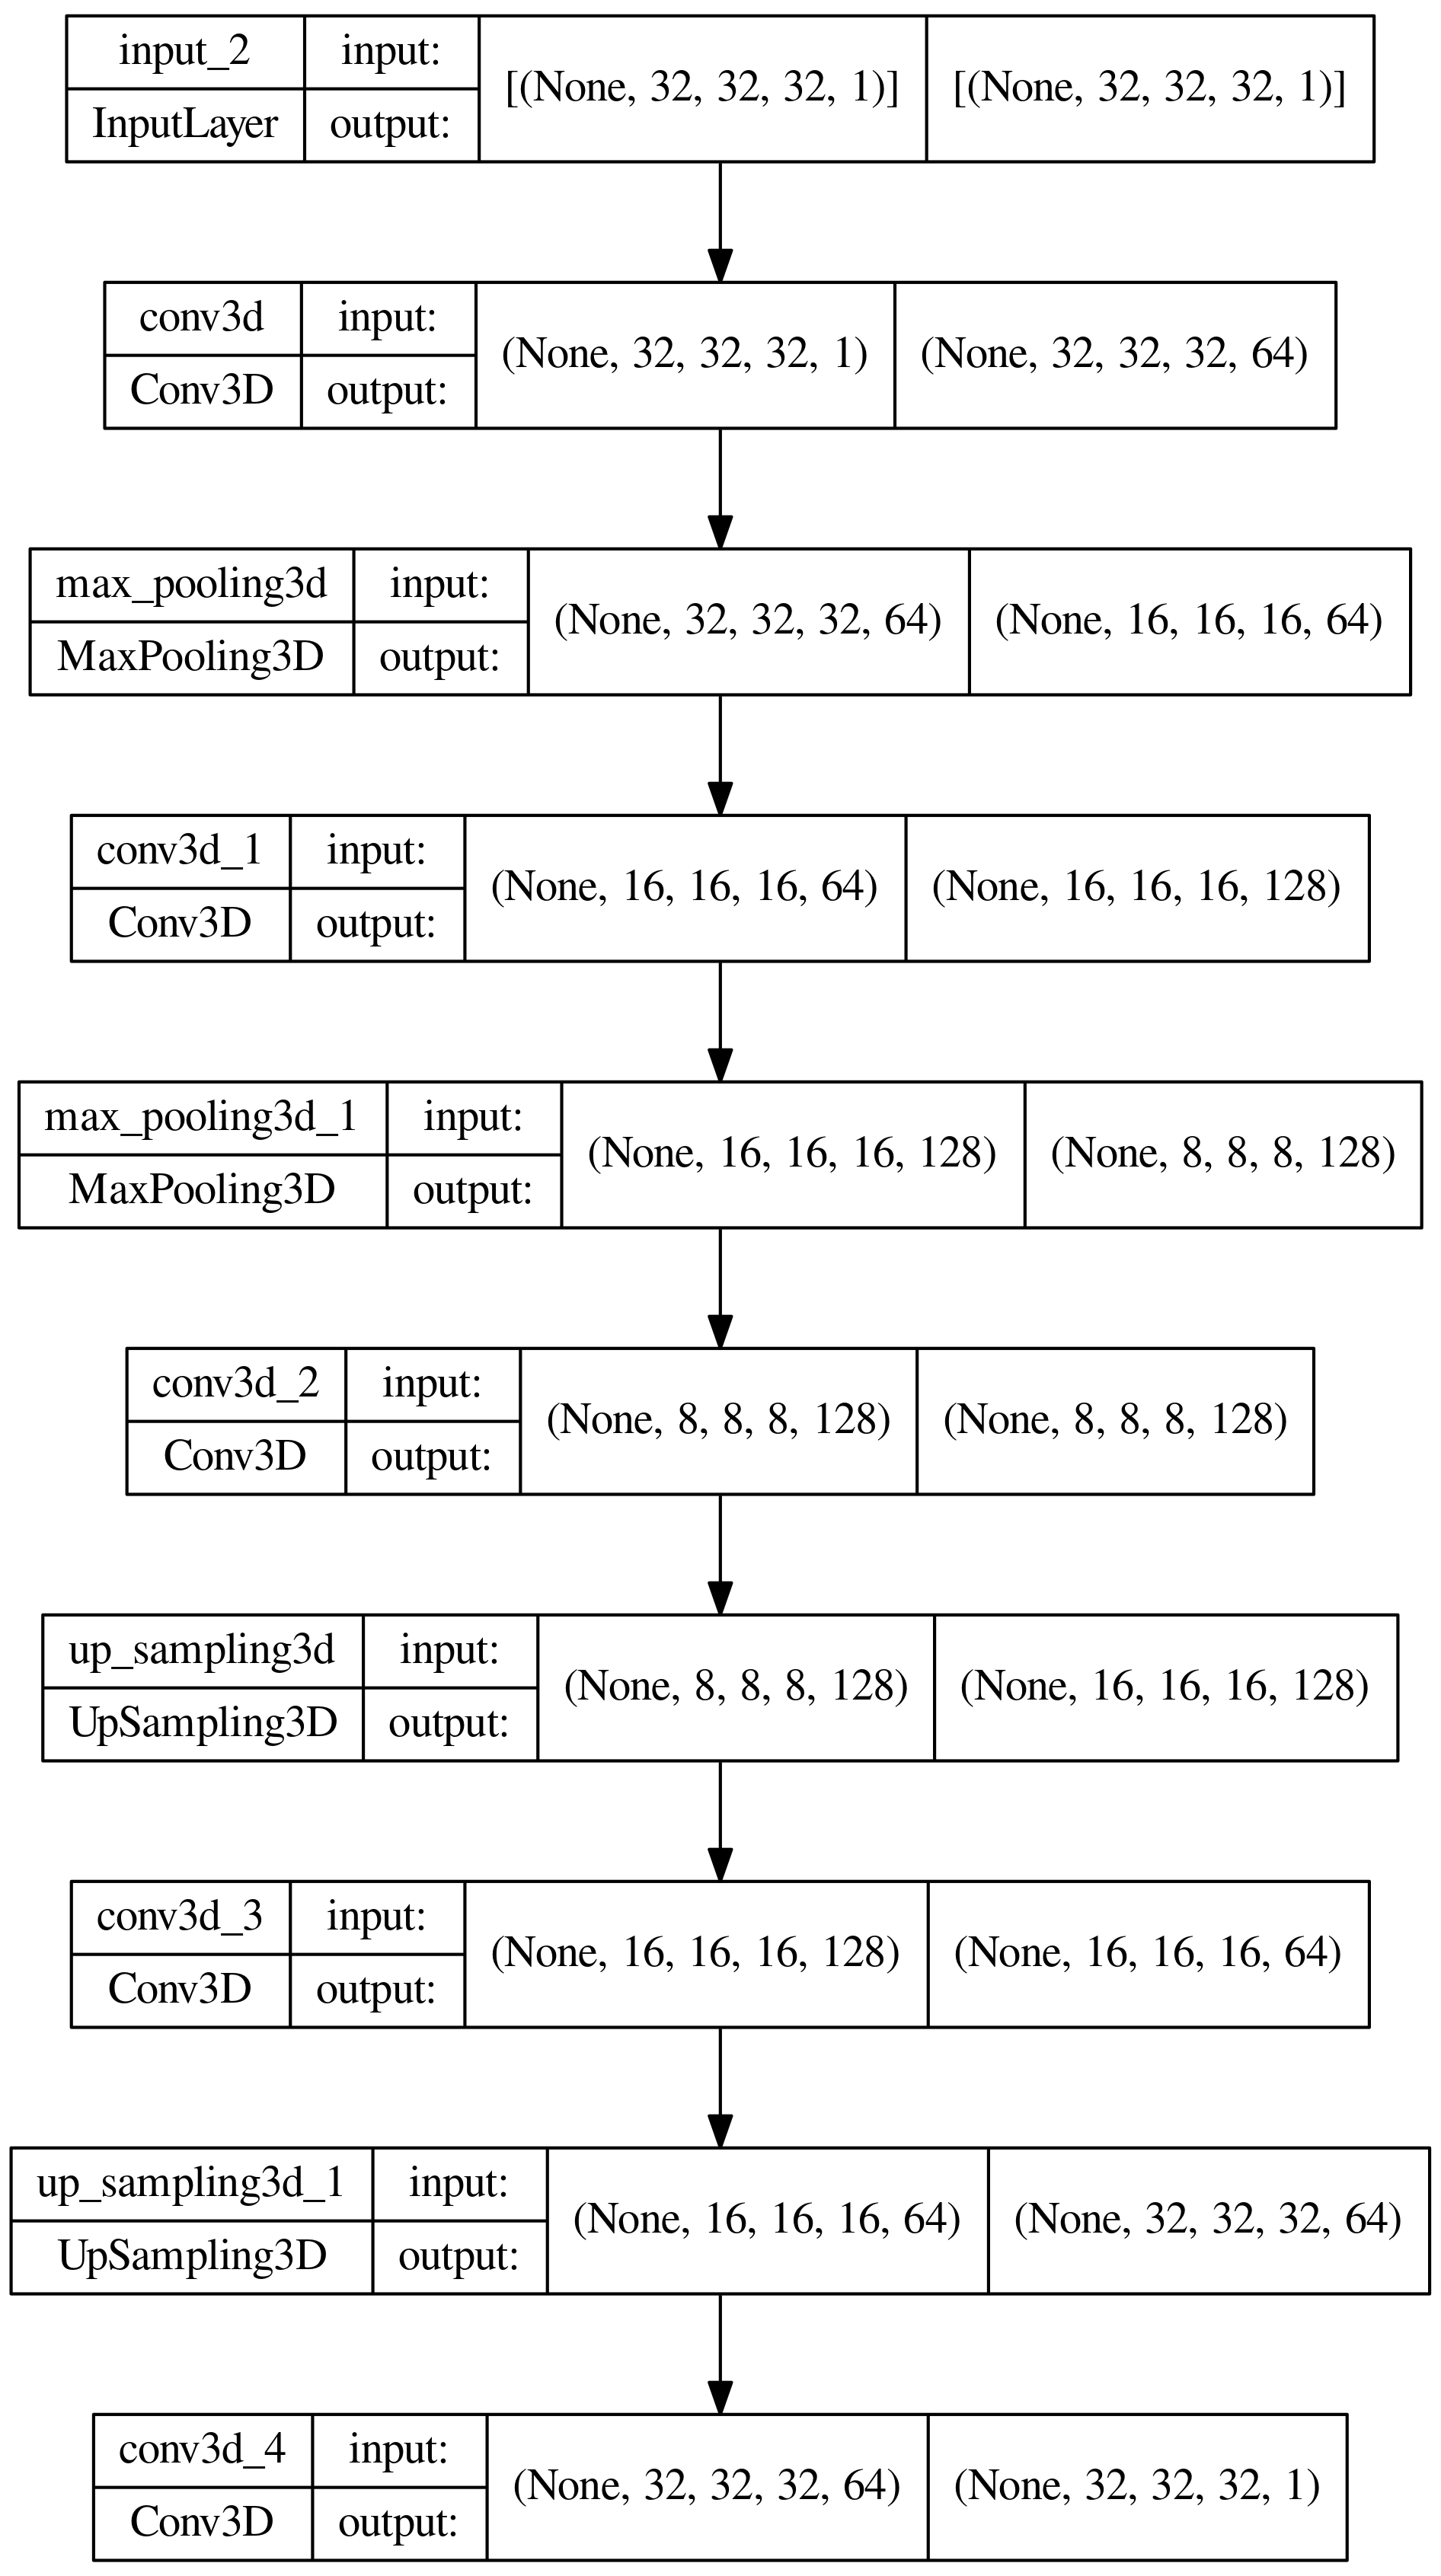

In [20]:
plot_model(enc_dec_model, 
           to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True, 
           dpi=300)